Obiettivi del task:
- Esplorare il dataset e comprendere la distribuzione dei valori
- Analizzare i dati forniti nel CSV per comprendere quali feature sono più rilevanti per la predizione del rating.
- Pulizia e preparazione dei dati (gestione valori mancanti, normalizzazione/standardizzazione, encoding delle variabili categoriche, feature scaling, etc.).
- Dividere il dataset in training e test set.
- Definire un modello di Machine Learning supervisionato per predire rating_target come variabile di output.
- Testare diversi algoritmi di regressione (come Regressione Lineare, Random Forest, XGBoost, o reti neurali) per trovare quello con la performance migliore.
- Valutare la performance del modello tramite metriche come MSE (Mean Squared Error) o MAE (Mean Absolute Error).
- Documentare il processo e i risultati ottenuti.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error


In [20]:
import sklearn
print(sklearn.__version__)

1.3.2


## Esporazione dei dati

In [14]:
file_path = './data/rating_stats.csv'
df = pd.read_csv(file_path, delimiter=';')

# Controllo delle prime righe del dataset per visualizzare i dati
df.head()

,id,player_name,player_id,fixture_id,league_round,rating,event_datetime,team_name,position,home_or_away,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,1,A. Barák,8779,390,1,0.0,17/08/2024 18:30,Fiorentina,Midfielder,away,...,0,0,0,0,0,0,0,0,0,0.0
1,2,A. Barák,8779,392,2,7.3,25/08/2024 18:30,Fiorentina,Midfielder,home,...,0,0,0,0,0,0,0,0,0,5.5
2,3,A. Bastoni,8619,384,1,6.9,17/08/2024 18:30,Inter,Defender,away,...,1,1,0,0,0,0,0,0,0,6.5
3,4,A. Bastoni,8619,394,2,7.2,24/08/2024 20:45,Inter,Defender,home,...,0,1,0,0,0,0,0,0,0,6.5
4,5,A. Bastoni,8619,404,3,7.5,30/08/2024 20:45,Inter,Defender,home,...,1,1,0,0,0,0,0,0,0,6.5


In [4]:
len(df)

2250

In [42]:
# differenza tra rating e rating target
df['rating_diff'] = df['rating'] - df['rating_target']

# Stats di base sulla differenza tra rating e rating target
diff_overall = df['rating_diff'].describe()

# 2. Statistiche di base sulla differenza, raggruppata per ruolo (position)
diff_by_position = df.groupby('position')['rating_diff'].describe()

# 3. Filtrare righe con rating_target > 0 and rating > 0 e calcolare le statistiche
filtered_df = df[(df['rating_target'] > 0)]
diff_filtered = filtered_df['rating_diff'].describe()

print(diff_overall) 
print(diff_by_position)
print(diff_filtered)


count    2250.000000
mean        0.845911
std         1.317449
min        -1.000000
25%         0.000000
50%         0.600000
75%         1.100000
max         7.300000
Name: rating_diff, dtype: float64
            count      mean       std  min  25%  50%  75%  max
position                                                      
Attacker    524.0  1.054198  1.566793 -0.5  0.0  0.7  1.2  7.3
Defender    778.0  0.825835  1.156733 -1.0  0.0  0.7  1.2  7.0
Goalkeeper  296.0  0.277365  0.543118 -0.6  0.0  0.0  0.4  3.6
Midfielder  652.0  0.960583  1.448383 -0.3  0.0  0.7  1.2  7.3
count    1420.000000
mean        0.919437
std         0.518294
min        -1.000000
25%         0.600000
50%         0.900000
75%         1.200000
max         3.600000
Name: rating_diff, dtype: float64


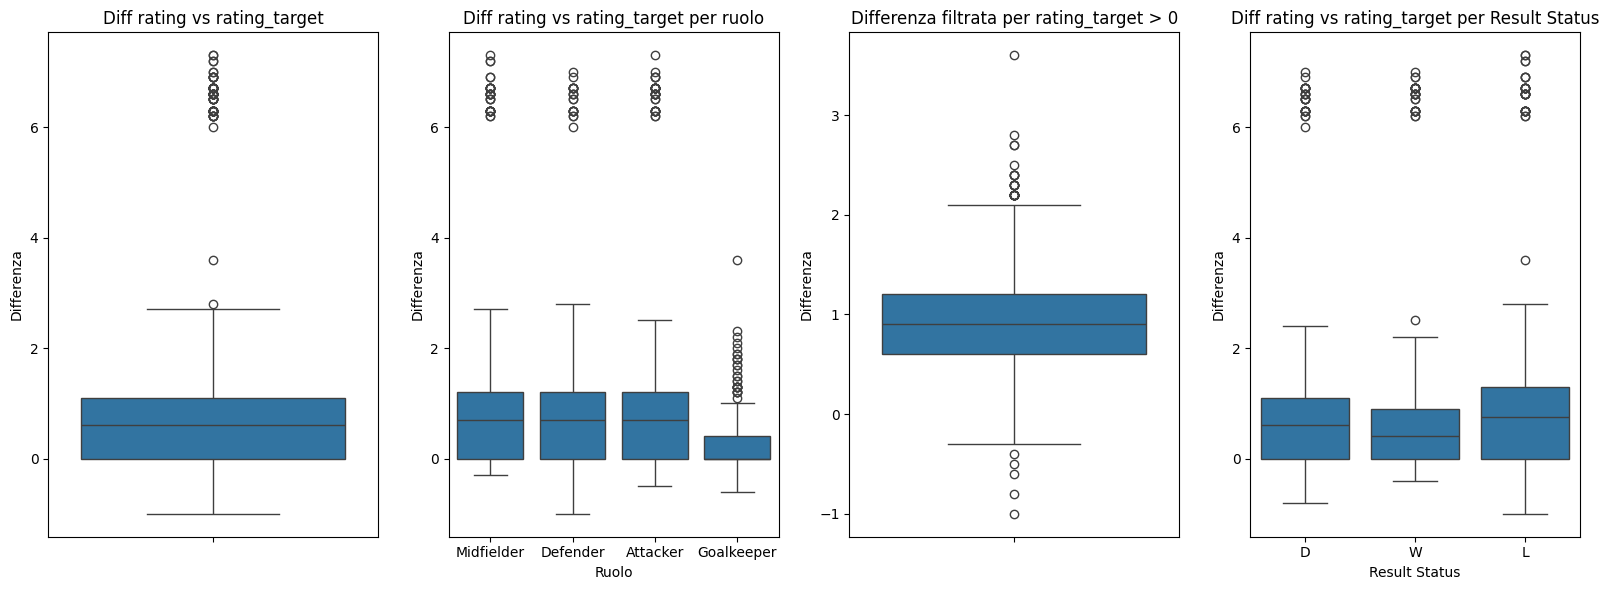

In [62]:
# Impostazioni per i grafici
plt.figure(figsize=(16, 6))

# 1. Boxplot della differenza complessiva tra rating_target e rating
plt.subplot(1, 4, 1)
sns.boxplot(y=df['rating_diff'])
plt.title('Diff rating vs rating_target')
plt.ylabel('Differenza')

# 2. Boxplot della differenza per ruolo (position)
plt.subplot(1, 4, 2)
sns.boxplot(x=df['position'], y=df['rating_diff'])
plt.title('Diff rating vs rating_target per ruolo')
plt.xlabel('Ruolo')
plt.ylabel('Differenza')

# 3. Boxplot delle righe filtrate con rating_target > 0
filtered_df = df[df['rating_target'] > 0]
plt.subplot(1, 4, 3)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Differenza filtrata per rating_target > 0')
plt.ylabel('Differenza')

# 4. Boxplot della differenza rispetto a result_status
plt.subplot(1, 4, 4)
sns.boxplot(x=df['result_status'], y=df['rating_diff'])
plt.title('Diff rating vs rating_target per Result Status')
plt.xlabel('Result Status')
plt.ylabel('Differenza')

plt.tight_layout()
plt.show()

In [67]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

df[(df['rating_diff'] > 5.5)]


,id,player_name,player_id,fixture_id,league_round,rating,event_datetime,team_name,position,home_or_away,opponent_team,result,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,rating_diff,residuals
80,81,A. Dembélé,9248,424,5,6.2,20/09/2024 20:45,Torino,Defender,away,Verona,2 - 3,W,8,VERO,0,0,0,0,0,0,0,8,0,5,1,0,0.0,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0.0,6.2,6.2
111,112,A. Gabrielloni,22766,409,3,6.3,01/09/2024 20:45,Como,Attacker,away,Udinese,1 - 0,L,18,VERO,0,0,0,0,0,0,0,2,0,1,0,0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.3,6.3
156,157,A. Makoumbou,9044,412,4,6.9,15/09/2024 18:00,Cagliari,Midfielder,home,Napoli,0 - 4,L,13,VERO,0,0,0,0,0,0,0,19,0,16,2,0,0.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.9,6.9
159,160,A. Manzoni,8748,399,2,6.6,25/08/2024 18:30,Atalanta,Midfielder,away,Torino,2 - 1,L,14,VERO,0,0,0,0,0,0,0,12,0,11,0,0,0.0,3,2,0,0,0,1,1,0,0,0,0,0,0,0,0.0,6.6,6.6
193,194,A. Obert,8528,391,2,6.5,26/08/2024 18:30,Cagliari,Defender,home,Como,1 - 1,D,9,VERO,0,0,0,0,0,0,0,2,0,1,0,0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,6.5,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,2093,T. Kristensen,9083,409,3,6.3,01/09/2024 20:45,Udinese,Defender,home,Como,1 - 0,W,18,VERO,0,0,0,0,0,0,0,2,0,1,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.3,6.3
2102,2103,T. Noslin,8917,406,3,6.3,31/08/2024 20:45,Lazio,Attacker,home,AC Milan,2 - 2,D,8,VERO,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.3,6.3
2162,2163,W. Bondo,8879,428,5,6.7,22/09/2024 15:00,Monza,Midfielder,home,Bologna,1 - 2,L,9,VERO,0,0,0,0,0,0,0,7,0,7,3,0,0.0,4,3,1,0,0,0,0,0,0,0,0,0,0,0,0.0,6.7,6.7
2183,2184,Y. Adli,8711,423,5,6.7,22/09/2024 12:30,Fiorentina,Midfielder,home,Lazio,2 - 1,W,14,VERO,0,0,0,0,0,0,0,8,0,7,0,0,0.0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0,6.7,6.7


## Pearson Correlation

The Pearson Correlation measures the linear dependence between two variables X and Y.

The resulting coefficient is a value between -1 and 1 inclusive, where:

- 1: Perfect positive linear correlation.
- 0: No linear correlation, the two variables most likely do not affect each other.
- -1: Perfect negative linear correlation.

In [12]:
correlation_matrix = df.corr(numeric_only=True)

# Ordina valori in base alla colonna 'rating_target'
correlation_sorted = correlation_matrix['rating_target'].sort_values(ascending=False)

print(correlation_sorted)

rating_target            1.000000
rating                   0.915187
games_minutes            0.831518
duels_total              0.653908
passes_total             0.637580
passes_accuracy          0.599826
duels_won                0.588330
tackles_total            0.436357
fouls_committed          0.434161
fouls_drawn              0.412376
shots_total              0.392151
passes_key               0.384282
dribbles_attempts        0.370427
tackles_interceptions    0.336876
shots_on                 0.319280
dribbles_past            0.317897
dribbles_success         0.309497
goals_total              0.254672
tackles_blocks           0.240208
cards_yellow             0.208838
goals_assists            0.190470
offsides                 0.172148
goals_saves              0.153502
goals_conceded           0.121866
penalty_scored           0.083673
penalty_won              0.077149
id                       0.071813
penalty_committed        0.039176
rating_diff              0.038590
penalty_saved 

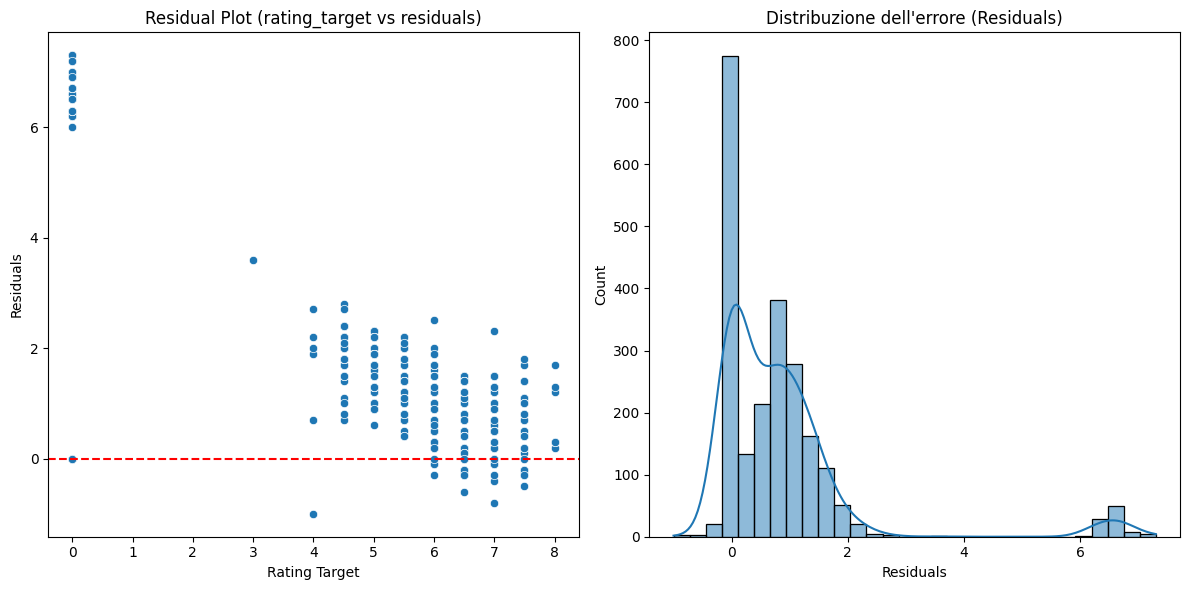

In [28]:
# 1. Residual Plot (Grafico dei residui)
plt.figure(figsize=(12, 6))

# Calcolare i residui (errore)
df['residuals'] = df['rating'] - df['rating_target']

# Residual plot: rating_target vs residui
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['rating_target'], y=df['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (rating_target vs residuals)')
plt.xlabel('Rating Target')
plt.ylabel('Residuals')

# 2. Distribuzione dell'errore
plt.subplot(1, 2, 2)
sns.histplot(df['residuals'], kde=True, bins=30)
plt.title('Distribuzione dell\'errore (Residuals)')
plt.xlabel('Residuals')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### MAE e RMSE

In [44]:
# 3. Errore medio assoluto (MAE)
mae = np.mean(np.abs(df['residuals']))
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calcola l'RMSE
rmse = np.sqrt(mean_squared_error(df['rating_target'], df['rating']))

print("RMSE:", rmse)

Mean Absolute Error (MAE): 0.85
RMSE: 1.5653966483504003


**1. Mean Absolute Error (MAE): 0.85**
In media, le previsioni del modello si discostano dai valori reali di 0.85 punti. Questo indica un errore medio relativamente contenuto nelle previsioni.
Un errore medio di 0.85, su un rating che potenzialmente va da 0 a 10, può essere considerato accettabile, suggerendo che il modello fornisce previsioni abbastanza affidabili.

**2. Root Mean Square Error (RMSE): 1.57**
L'RMSE indica che in media, l'errore quadratico delle previsioni è di 1.57 punti. Questa metrica penalizza maggiormente gli errori più grandi a causa dell'elevamento al quadrato.
Quindi, sebbene ci siano alcune previsioni vicine ai valori reali, ci sono anche errori significativi che influenzano il risultato finale. Questo potrebbe indicare che il modello ha difficoltà a prevedere valori estremi o situazioni particolari.

**Confronto tra MAE e RMSE:**
Il MAE è generalmente più robusto e non è influenzato dagli outlier tanto quanto l'RMSE. Se il MAE è significativamente più basso dell'RMSE, potrebbe essere un segno di outlier nel tuo dataset.

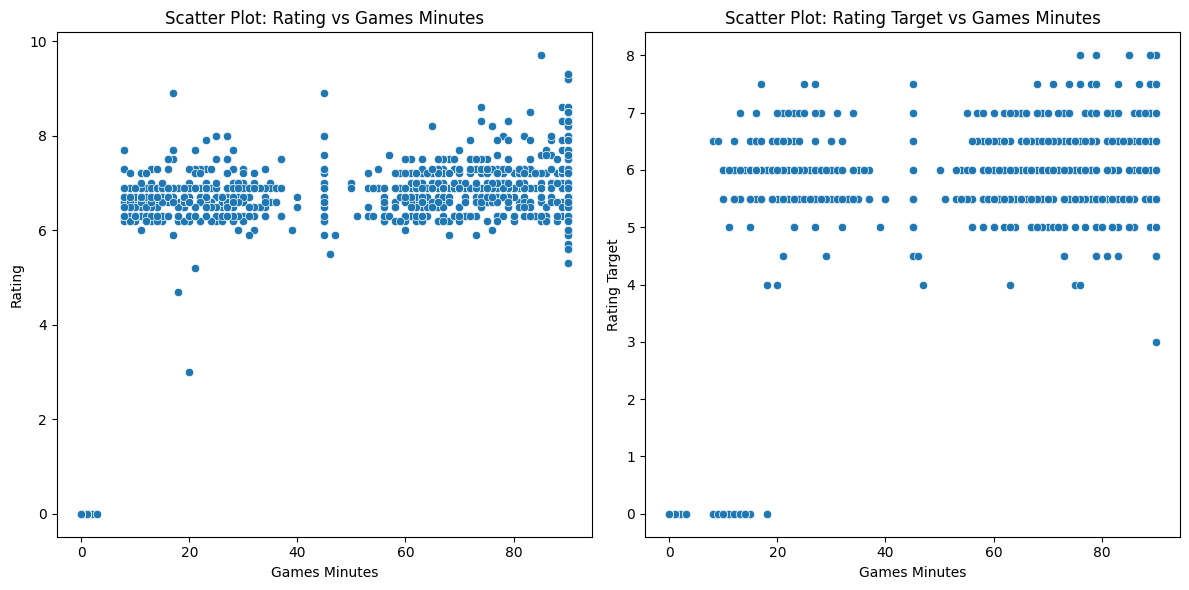

In [54]:
plt.figure(figsize=(12, 6))

# Scatter plot per rating rispetto a games_minutes
plt.subplot(1, 2, 1)
sns.scatterplot(x='games_minutes', y='rating', data=df)
plt.title('Scatter Plot: Rating vs Games Minutes')
plt.ylabel('Rating')
plt.xlabel('Games Minutes')

# Scatter plot per rating_target rispetto a games_minutes
plt.subplot(1, 2, 2)
sns.scatterplot(x='games_minutes', y='rating_target', data=df)
plt.title('Scatter Plot: Rating Target vs Games Minutes')
plt.ylabel('Rating Target')
plt.xlabel('Games Minutes')

plt.tight_layout()
plt.show()